Matteo Picciolini

# Esercitazione 10

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 10 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 10, is characterized by a different temperature or a limited set of temperatures (if you need more than 10 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Risoluzione
Per questa esercitazione ho scelto di parallelizzare con MPI il codice genetico che ho scritto per l'esercitazione precedente ed effettuare delle migrazioni ogni $N_{migr}$ generazioni.

#### Parallelizzazione
Un processo di parallelizzato è un processo che suddivide un problema in sottoproblemi che possono essere eseguiti simultaneamente su più processori o core di calcolo. Questo approccio consente di sfruttare al massimo le risorse computazionali disponibili, accelerando l'esecuzione complessiva e consentendo di risolvere problemi più grandi o complessi. La parallelizzazione può essere ottenuta utilizzando modelli di programmazione parallela come MPI (Message Passing Interface).

#### Libreria MPI
MPI (Message Passing Interface) è una libreria scritta in c++ per la comunicazione e il coordinamento tra processi paralleli. Le applicazioni MPI sono composte da un insieme di processi che comunicano tra loro scambiando messaggi. Ogni processo ha un identificatore unico, chiamato *rank*, che viene utilizzato per identificarlo nel contesto della comunicazione. La libreria MPI fornisce funzioni per la gestione dei processi, la comunicazione tra i processi e la sincronizzazione. Le principali operazioni offerte da MPI includono l'invio e la ricezione di messaggi, la riduzione di dati, la raccolta e la diffusione di dati, la sincronizzazione dei processi e altro ancora.

Mostro ora alcuni comandi della libreria che ho utilizzato:
- `int MPI_Init(int *argc, char **argv)`: Questo comando inizializza l'ambiente di esecuzione MPI. Deve essere chiamato all'inizio del programma MPI prima di qualsiasi altra operazione MPI. Prende due argomenti: il puntatore `argc` all'argomento di linea di comando del programma e il puntatore `argv` all'array di argomenti di linea di comando. MPI_Init si occupa di inizializzare l'ambiente MPI e di eseguire la configurazione iniziale dei processi MPI.
- `int MPI_Comm_size(MPI_Comm comm, int *size)`: Questo comando restituisce il numero totale di processi nel comunicatore `comm` e lo memorizza nella variabile `size`. Tipicamente come `MPI_Comm` si utilizza `MPI_COMM_WORLD`, che rappresenta tutti i processi disponibili.
- `int MPI_Comm_rank(MPI_Comm comm, int *rank)`:  Questo comando restituisce il rank di ciascun processo all'interno del comunicatore `comm` e lo memorizza nella variabile rank. Il rank identifica univocamente ciascun processo all'interno di `comm`.
- `int MPI_Bcast( void *buffer, int count, MPI_Datatype datatype, int root, MPI_Comm comm )`: Questa funzione è utilizzata per trasmettere un dato processo (`root`) a tutti gli altri processi all'interno di un comunicatore specificato. `buffer` è il puntatore alla varibile che si vuole trasmettere dal processo `root` agli altri processi. `cout` è il numeri di elementi che si vuole trasmettere. `datatype` è il tipo di dato dell'elemento nel buffer: è tipicamente un tipo predefinito MPI. `root` è il rank del processo che invia il dato. `comm` è il comunicatore che definisce il gruppo di processi coinvolti nella comunicazione. 
- `int MPI_Send(const void *buffer, int count, MPI_Datatype datatype, int dest, int tag, MPI_Comm comm)`: Questa funzione è utilizzata per inviare un messaggio da un processo sorgente a un processo destinatario all'interno di uno stesso comunicatore. I parametri sono gli stessi che per il comando precendente, a parte alcuni: `dest` è il rank del processo di destinazione, mentre `tag` è un identificatore univoco per il messaggio. Quest'ultimo viene utilizzato per distinguere i messagi inviati da `MPI_Send` e `MPI_Recv` che hanno stesso mittente e destinatario.
- `int MPI_Recv(void *buf, int count, MPI_Datatype datatype, int source, int tag, MPI_Comm comm, MPI_Status *status)`: questa funzione, è invece, utilizzata per ricevere un messagio da un processo sorgente specificato all'interno del comunicatore. L'unico parametro in più è il parametro `status` che, una volta eseguita la funzione, conterrà informazioni sull'esito della ricezione del messagio. IMPORTANTE: `MPI_Recv` è una chiamata bloccante, il che significa che il processo destinazione viene sospeso finché non riceve effettivamente il messaggio. Il messaggio viene correttamente ricevuto solo quando la chiamata MPI_Recv ritorna.

#### Commenti sul codice
Per completare l'esercizio, ho lasciato quasi intatta la struttura della libreria e ho modificato solo il `main`. Le funzioni che ho modificato sono state le funzioni di scrittura dei dati su file esterni, in modo che il nome dei file di uscita contenga il rank che lo ha generato.

La modifica del `main` non è stata sostanziale, anche perché il processo da eseguire, a grandi linee è sempre lo stesso. Le modifiche importanti sono state fatte all'interno del ciclo `for` che itera sulle diverse generazioni. Riporto di seguito il frammento di codice che interessa le migrazioni.

```c++
if(!migrate || (migrate && i % migration_freq != 0) || i == 0){ // continenti indipendenti -> no migrazioni
            population.reproduce(rnd);
}
else if(migrate && i % migration_freq == 0){
    int h = 0, giver = 0, receiver = 1;
    int migrator[Ngenes];
    i_tag = i + 1;

    if(rank == 0){
        h = (int)(population.get_n_individuals() * (1 - pow(rnd.Rannyu(), 6))) - 1; 
        do{
            giver = (int)rnd.Rannyu(0, size);     // scelgo il core di partenza
            receiver = (int)rnd.Rannyu(0, size);  // scelgo il core di arrivo... 
        }while(receiver == giver); // finchè giver e receiver sono uguali continuo il ciclo
    }

    // il rank 0 manda le variabili h, giver, receiver agli altri
    MPI_Bcast(&h, 1, MPI_INTEGER, 0, MPI_COMM_WORLD);
    MPI_Bcast(&giver, 1, MPI_INTEGER, 0, MPI_COMM_WORLD); 
    MPI_Bcast(&receiver, 1, MPI_INTEGER, 0, MPI_COMM_WORLD);

    // se sono il donatore dono l'individuo h-esimo
    if(rank == giver){
        // salvo l'individuo in migrator
        for(int i = 0; i < Ngenes; i++){
            migrator[i] = population.individuals[h].get_gene(i);
        }
        // invo migrator al processo specificato come receiver
        MPI_Send(migrator, Ngenes, MPI_INTEGER, receiver, i_tag, MPI_COMM_WORLD);
    }

    // se sono il ricevitore lo inserisco nella popolazione
    if(rank == receiver){
        MPI_Recv(migrator, Ngenes, MPI_INTEGER, giver, i_tag, MPI_COMM_WORLD, &stat);
        population.individuals[h].set_genes(migrator); 
        population.individuals[h].check();
    }
}

```

Come si può vedere da questo specchietto, la scelta dell'individuo da migrare è data dalla stessa legge di potenza dell'esercitazione precedente: $$j= \text{int}\left[M \cdot (1- r^p)\right]+1,$$ con $p = 6$.

#### Usage
Per lanciare il programma da linea di comando è necessario predisporre la macchina al calcolo parallelo. Per questo per lanciare correttamente il programma è necessario utilizzare il comando `mpiexec`. Mostro di seguito l'usage del programma:

```
mpiexec -np <rank_number> Exercise_10.1 <migrate> <migration_freq> <print_city>  with <migrate> and <print_city> = {true, false} and <migration_freq> = unsign int type
```
Nel mio caso ho utilizzato `<rank_number>` = $4$.

Di seguito illustro un'animazione che mostra che all'attivazione del programma la mia macchina attiva tutti e $4$ i core disponibili.

<img src="../Data/10.1_core_animation.gif"/>



#### Quadrato: continenti indipendenti
Mostro ora i risultati che ho ottenuto per un sistema costituito da $34$ città distribuite uniformemente all'interno di un quadrato di lato $2$. Per queste simulazioni ho utilizzato $500$ generazioni ognuna costituita da $1000$ individui. Ho poi utilizzato le stesse percentuali di mutazione del corrispondente esercizio della scorsa lezione, ad eccezione del `crossover`, dove per questa volta ho utilizzato una percentuale del $50%$.

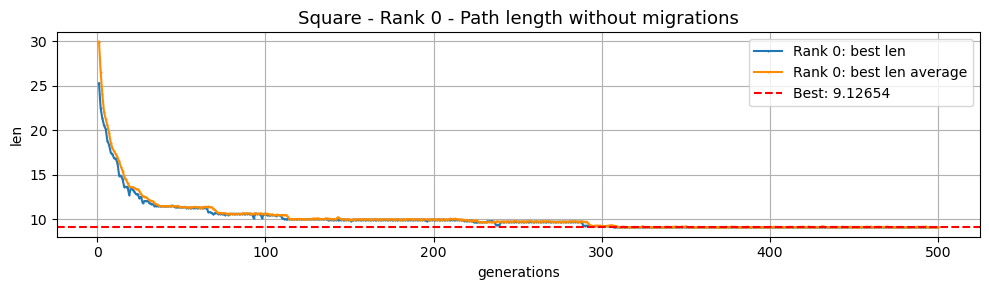

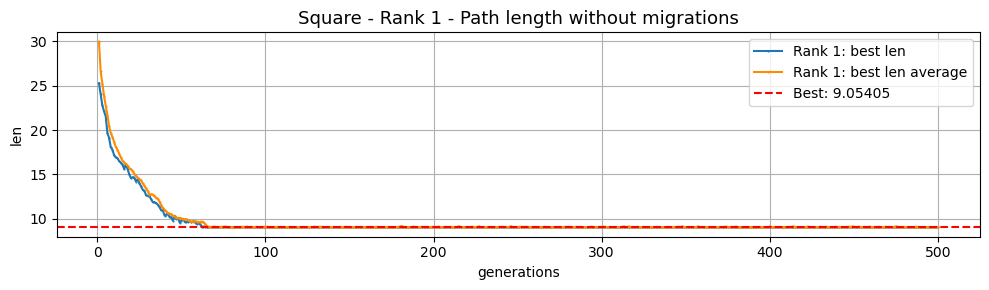

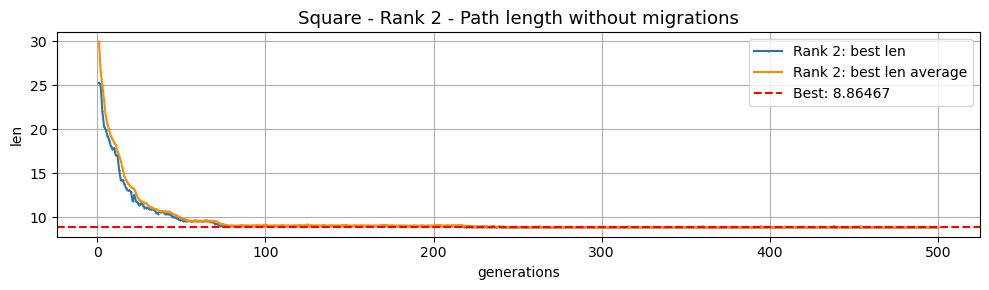

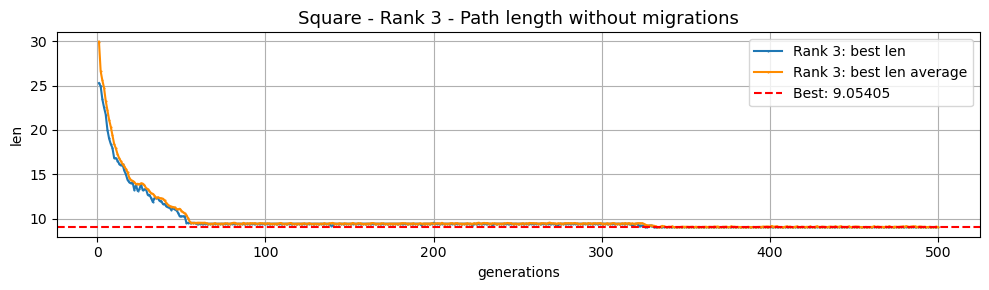

In [2]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_square_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_square_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 0 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_square_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_square_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 1 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_square_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_square_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 2 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_square_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_square_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 3 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Quadrato: migrazioni
Mostro ora i risultati che ho ottenuto con la simulazione con gli stessi parametri ma con implementato l'algoritmo delle migrazioni. Ho impostato, inoltre, una migrazione ogni $10$ generazioni.

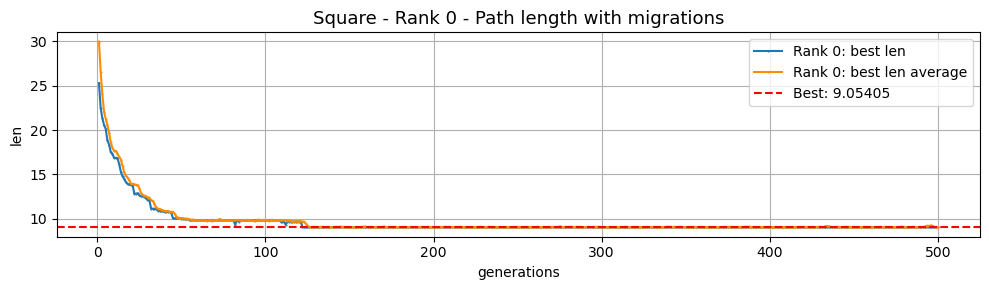

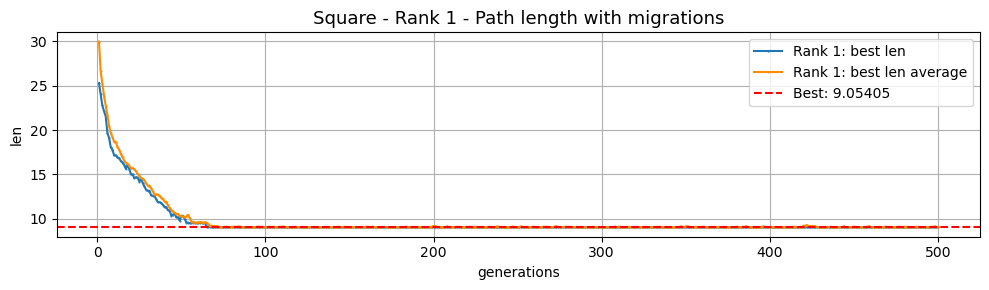

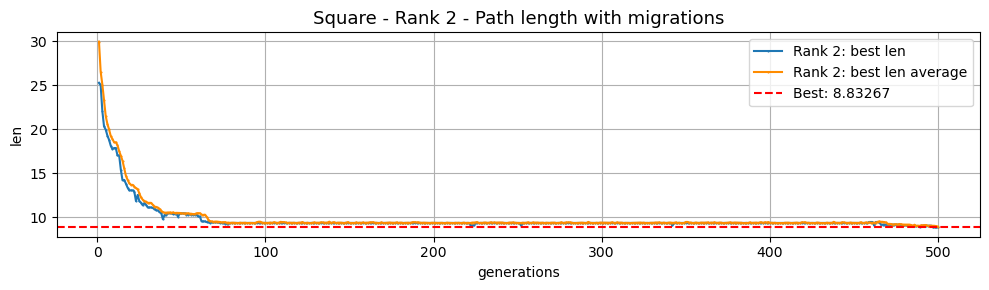

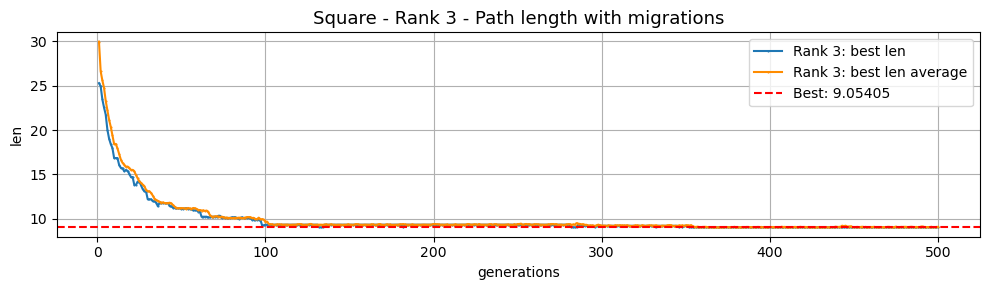

In [3]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_square_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_square_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 0 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_square_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_square_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 1 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_square_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_square_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Square - Rank 2 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_square_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_square_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: " + str(y_best_len[499]))
plt.title('Square - Rank 3 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Come si può vedere, tra una simualzione con migrazioni e una senza non ci sono particolari miglioramenti, ad eccezione del rank $2$ che è l'unico rank a trovare una soluzione migliore (anche se di poco). In realtà, non ci aspettiamo di vedere significativi, miglioramenti, perché altrimenti vorrebbe dire che l'algoritmo genetico di base, senza parallelizzazione o migrazioni, ha impostati dei parametri che non favoriscono una convergenza ottimale verso la soluzione. 

In ogni caso, è interessante notare che, in questo caso, le migrazioni hanno permesso di raggiungere, a parità di parametri, una soluzione migliore. 

### Exercise 10.2

Apply your parallel code to the TSP problem for 50 american state-capitals longitude and latitude coordinates in the *American_capitals.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

### Risolusione

#### Città americane: continenti indipendenti

Per caricare la posizione delle città implemnto una funzione apposita nella classe `Task`: `void load_cities(std::string filename);`. Dopodiché utilizzo lo stesso algoritmo di prima per ottenere i seguenti risultati per una simulazione senza migrazioni.

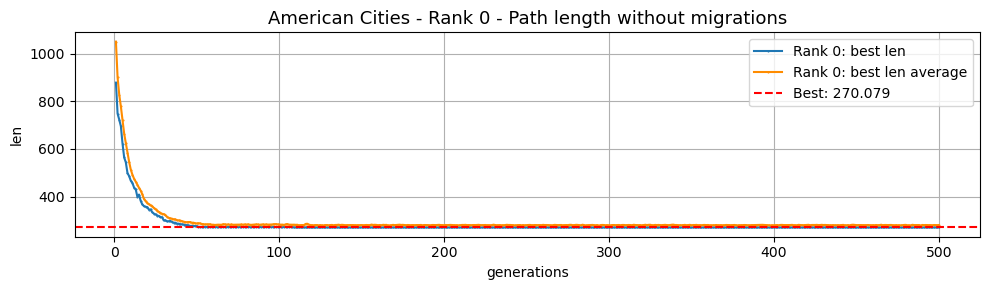

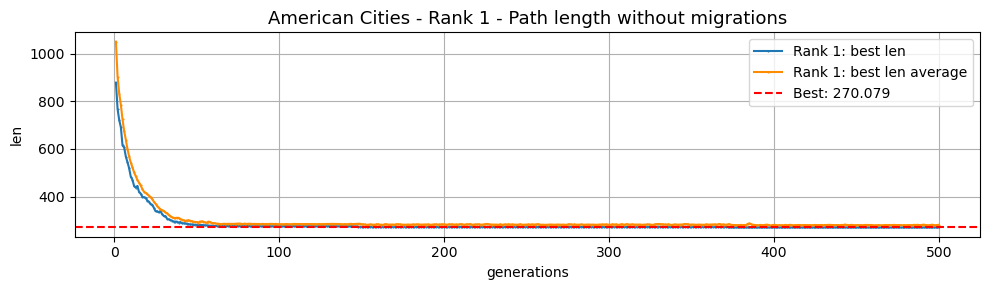

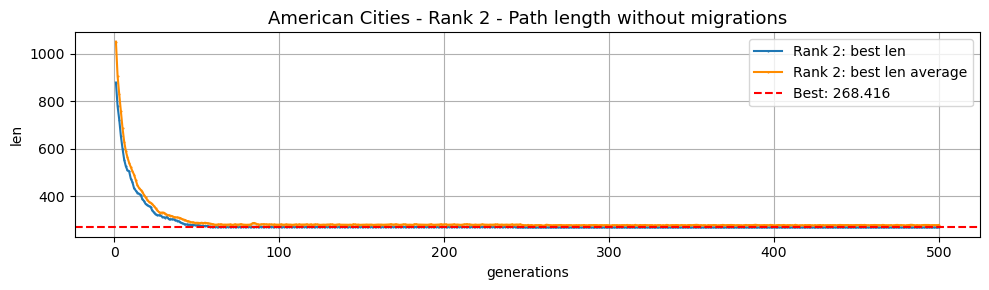

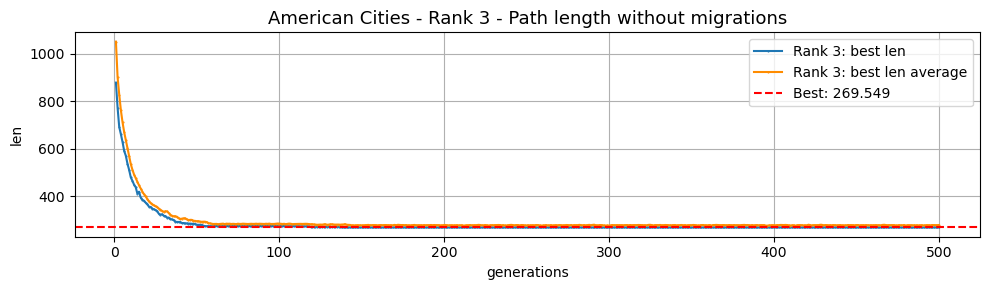

In [4]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_american_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_american_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 0 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_american_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_american_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 1 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_american_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_american_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 2 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_american_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_american_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 3 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Per queste simulazioni ho utilizzato $5000$ individui per popolazione e $500$ generazioni. Gli altri parametri sono tutti uguali a quelli delle simulazioni dell'esercizio precedente.

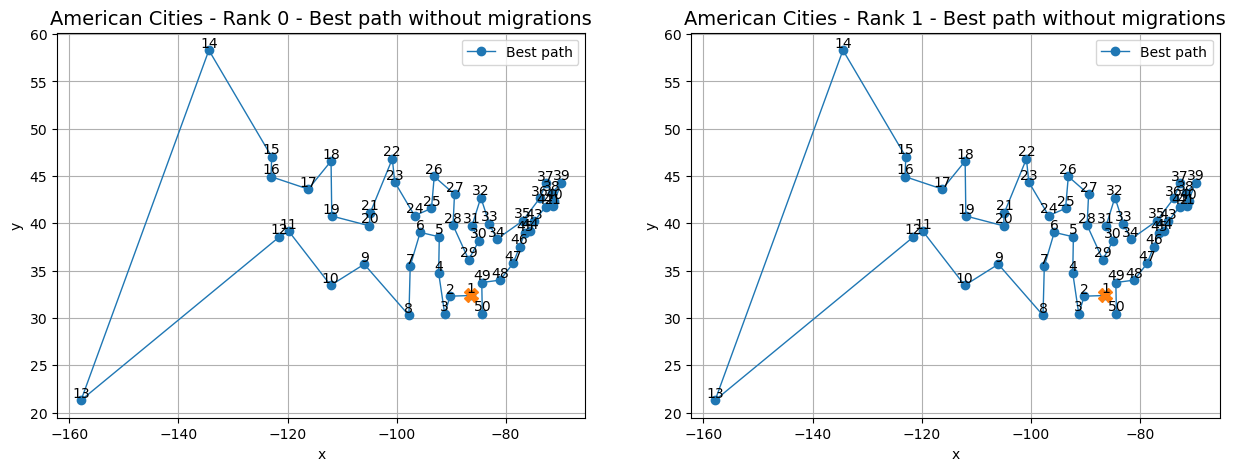

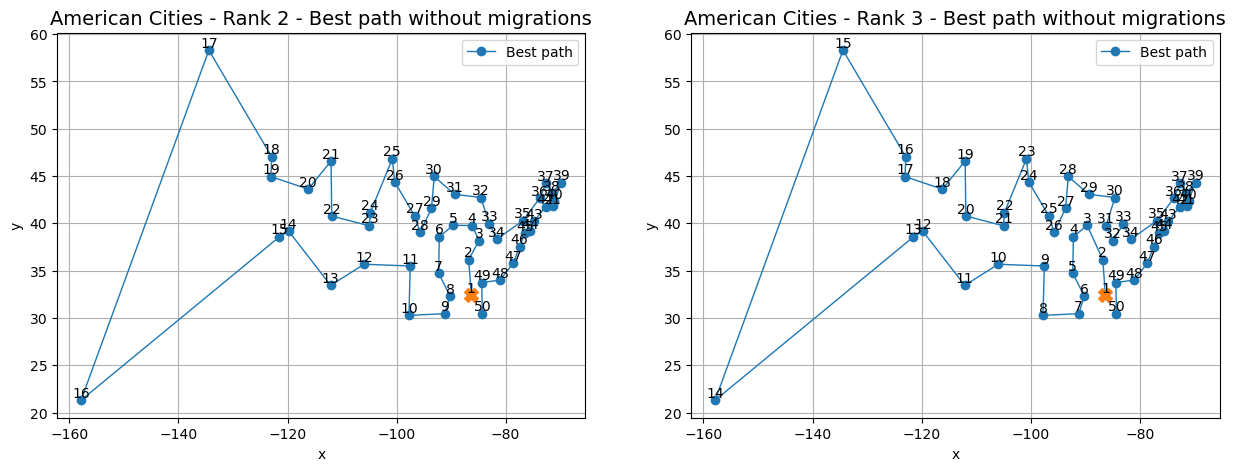

In [5]:
# FIRST ROW

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_false_american_0_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
axs[0].plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    axs[0].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[0].plot(x[0], y[0], marker = "X", markersize = 10)
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].grid(True)
axs[0].set_title('American Cities - Rank 0 - Best path without migrations', fontsize = 14)
axs[0].legend();


x, y = np.loadtxt("../Data/10.1_city_coord_false_american_1_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
plt.plot(x, y, marker = "o", lw = "1", linestyle = '-', label = 'Best path')
for i in range(len(x)):
    axs[1].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[1].plot(x[0], y[0], marker = "X", markersize = 10)
axs[1].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].grid(True)
axs[1].set_title("American Cities - Rank 1 - Best path without migrations", fontsize = 14)
axs[1].legend(loc = "upper right");
plt.show()


#SECOND ROW
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_false_american_2_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
axs[0].plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    axs[0].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[0].plot(x[0], y[0], marker = "X", markersize = 10)
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].grid(True)
axs[0].set_title('American Cities - Rank 2 - Best path without migrations', fontsize = 14)
axs[0].legend();


x, y = np.loadtxt("../Data/10.1_city_coord_false_american_3_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
plt.plot(x, y, marker = "o", lw = "1", linestyle = '-', label = 'Best path')
for i in range(len(x)):
    axs[1].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[1].plot(x[0], y[0], marker = "X", markersize = 10)
axs[1].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].grid(True)
axs[1].set_title("American Cities - Rank 3 - Best path without migrations", fontsize = 14)
axs[1].legend(loc = "upper right");
plt.show()


Mostro di seguito l'animazione relativa al rank $0$.

<img src="../Data/10.1_false_animation.gif"/>

#### Città americane: migrazioni

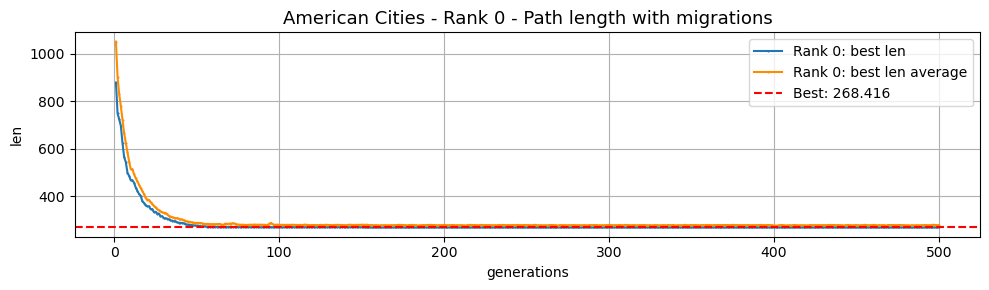

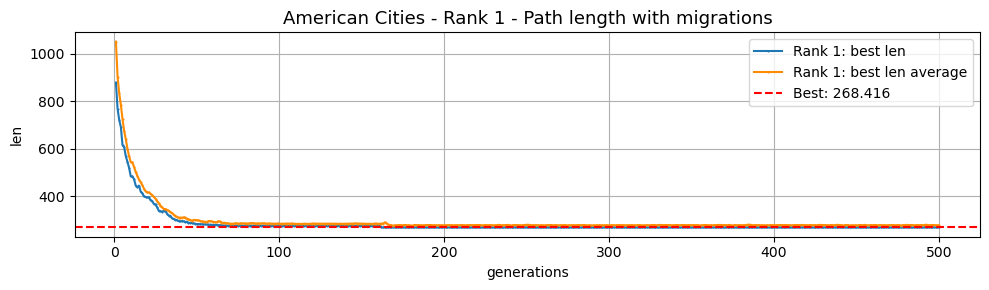

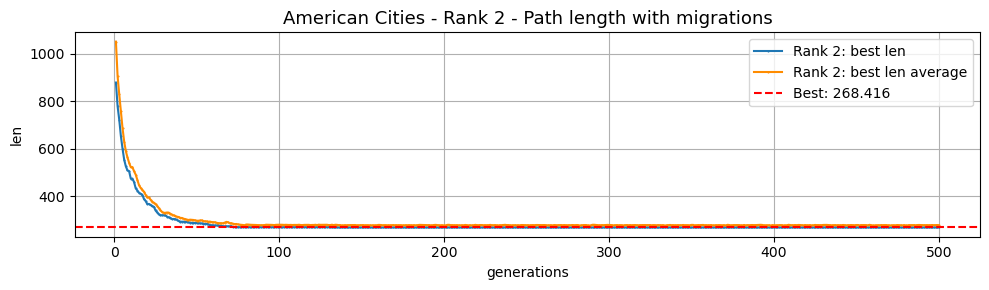

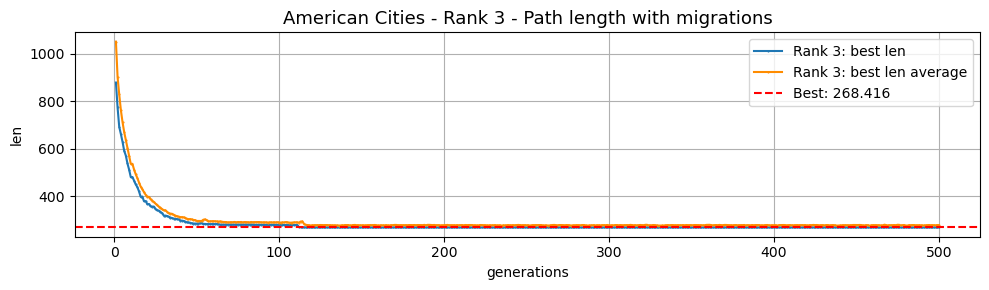

In [6]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_american_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_american_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 0 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_american_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_american_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 1 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_american_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_american_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('American Cities - Rank 2 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_american_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_american_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: " + str(y_best_len[499]))
plt.title('American Cities - Rank 3 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Come si può vedere dai grafici, in questo caso l'utilizzo delle migrazioni a fatto si che tutti i rank trovassero la soluzione ottimale trovata precedentemente dal rank 2 in condizioni di continenti indipendenti. In questo caso non c'è stato nessun margine di miglioramento tra la soluzione ottenuta con le migrazioni e quella ottenuta senza.

Mostro di seguito la soluzione migliore che ha trovato l'algoritmo.

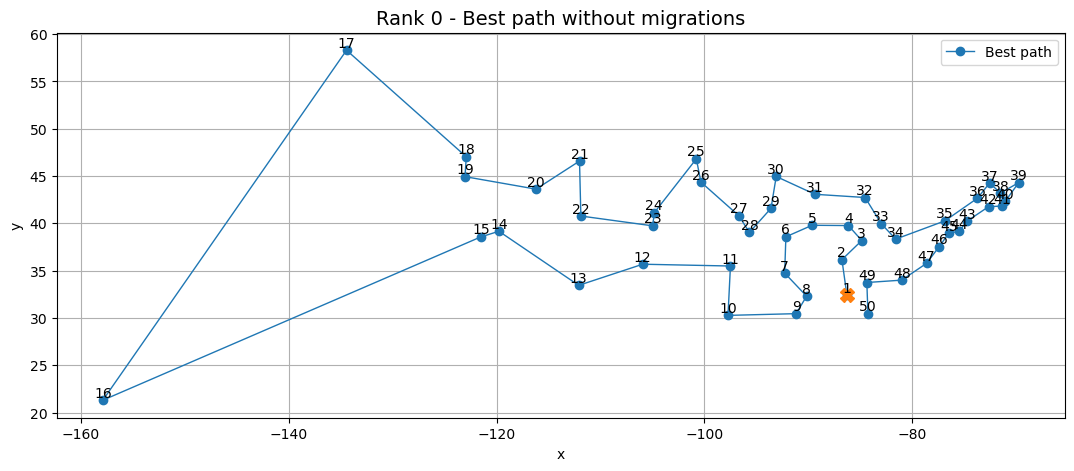

In [8]:
# FIRST ROW

fig, ax = plt.subplots(figsize = (13, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_true_american_0_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
ax.plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    ax.text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
ax.plot(x[0], y[0], marker = "X", markersize = 10)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.grid(True)
ax.set_title('American cities - Rank 0 - Best path without migrations', fontsize = 14)
ax.legend();
plt.show()

<img src="../Data/10.1_true_animation.gif"/>

#### Conclusioni

Dopo tante esecuzioni del programma posso confermare, almeno per questi casi specifici, è molto più importante utilizzare parametri appropriati per la probabilità delle mutazioni, piuttosto che aumentare il numero di migrazioni. Tendenzialmente ho notato che l'introduzione delle migrazioni non rallenta significativamente il codice, quindi, nel complesso, è vantaggioso utilizzarle, perché a parità di parametri, individui e generazioni, forniscono una soluzione leggermente migliore (magari anche solo per il fatto che tutti i rank convergono alla stessa soluzione, per cui si può avere una sicurezza in più del fatto che la soluzione trovata sia un minimo assoluto piuttosto che un minimo locale). 